In [1]:
# Downloading and unzipping the dataset
# !kaggle datasets download -p ../Datasets/ -d fedesoriano/heart-failure-prediction --unzip

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Finding data files
import os

for dirname, _, filenames in os.walk('..\Datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

..\Datasets\heart_failure.csv
..\Datasets\UCI-Wisconsin-Breast-Cancer-Dataset.csv


In [4]:
# Data

data = r"..\Datasets\heart_failure.csv"
df = pd.read_csv(data, header=0)

In [5]:
df.shape

(918, 12)

In [6]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [7]:
# X, y split

X = df.drop(columns=['HeartDisease'], axis='columns')
y = df['HeartDisease']

In [8]:
X.shape, y.shape

((918, 11), (918,))

In [9]:
# Data Mapping

# M: 0, F: 1
sex_mapping = {'M': 0, 'F': 1}

# TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic
chest_pain_type_mapping = {'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3}

# [Normal: Normal, ST: having ST-T wave abnormality, LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
resting_ecg_mapping = {'Normal': 0, 'ST': 1, 'LVH': 2}

# ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
exercise_angina_mapping = {'N': 0, 'Y': 1}

# ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
st_slope_mapping = {'Up': 1, 'Flat': 0, 'Down': -1}

def map_vals_to_nums(df, sex_mapping = sex_mapping, chest_pain_type_mapping = chest_pain_type_mapping, resting_ecg_mapping = resting_ecg_mapping, exercise_angina_mapping = exercise_angina_mapping, st_slope_mapping = st_slope_mapping):
    df['Sex'].replace(sex_mapping, inplace=True)
    df['ChestPainType'].replace(chest_pain_type_mapping, inplace=True)
    df['RestingECG'].replace(resting_ecg_mapping, inplace=True)
    df['ExerciseAngina'].replace(exercise_angina_mapping, inplace=True)
    df['ST_Slope'].replace(st_slope_mapping, inplace=True)

In [10]:
map_vals_to_nums(X)
map_vals_to_nums(df)

In [11]:
X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,0,1,140,289,0,0,172,0,0.0,1
1,49,1,2,160,180,0,0,156,0,1.0,0
2,37,0,1,130,283,0,1,98,0,0.0,1
3,48,1,3,138,214,0,0,108,1,1.5,0
4,54,0,2,150,195,0,0,122,0,0.0,1


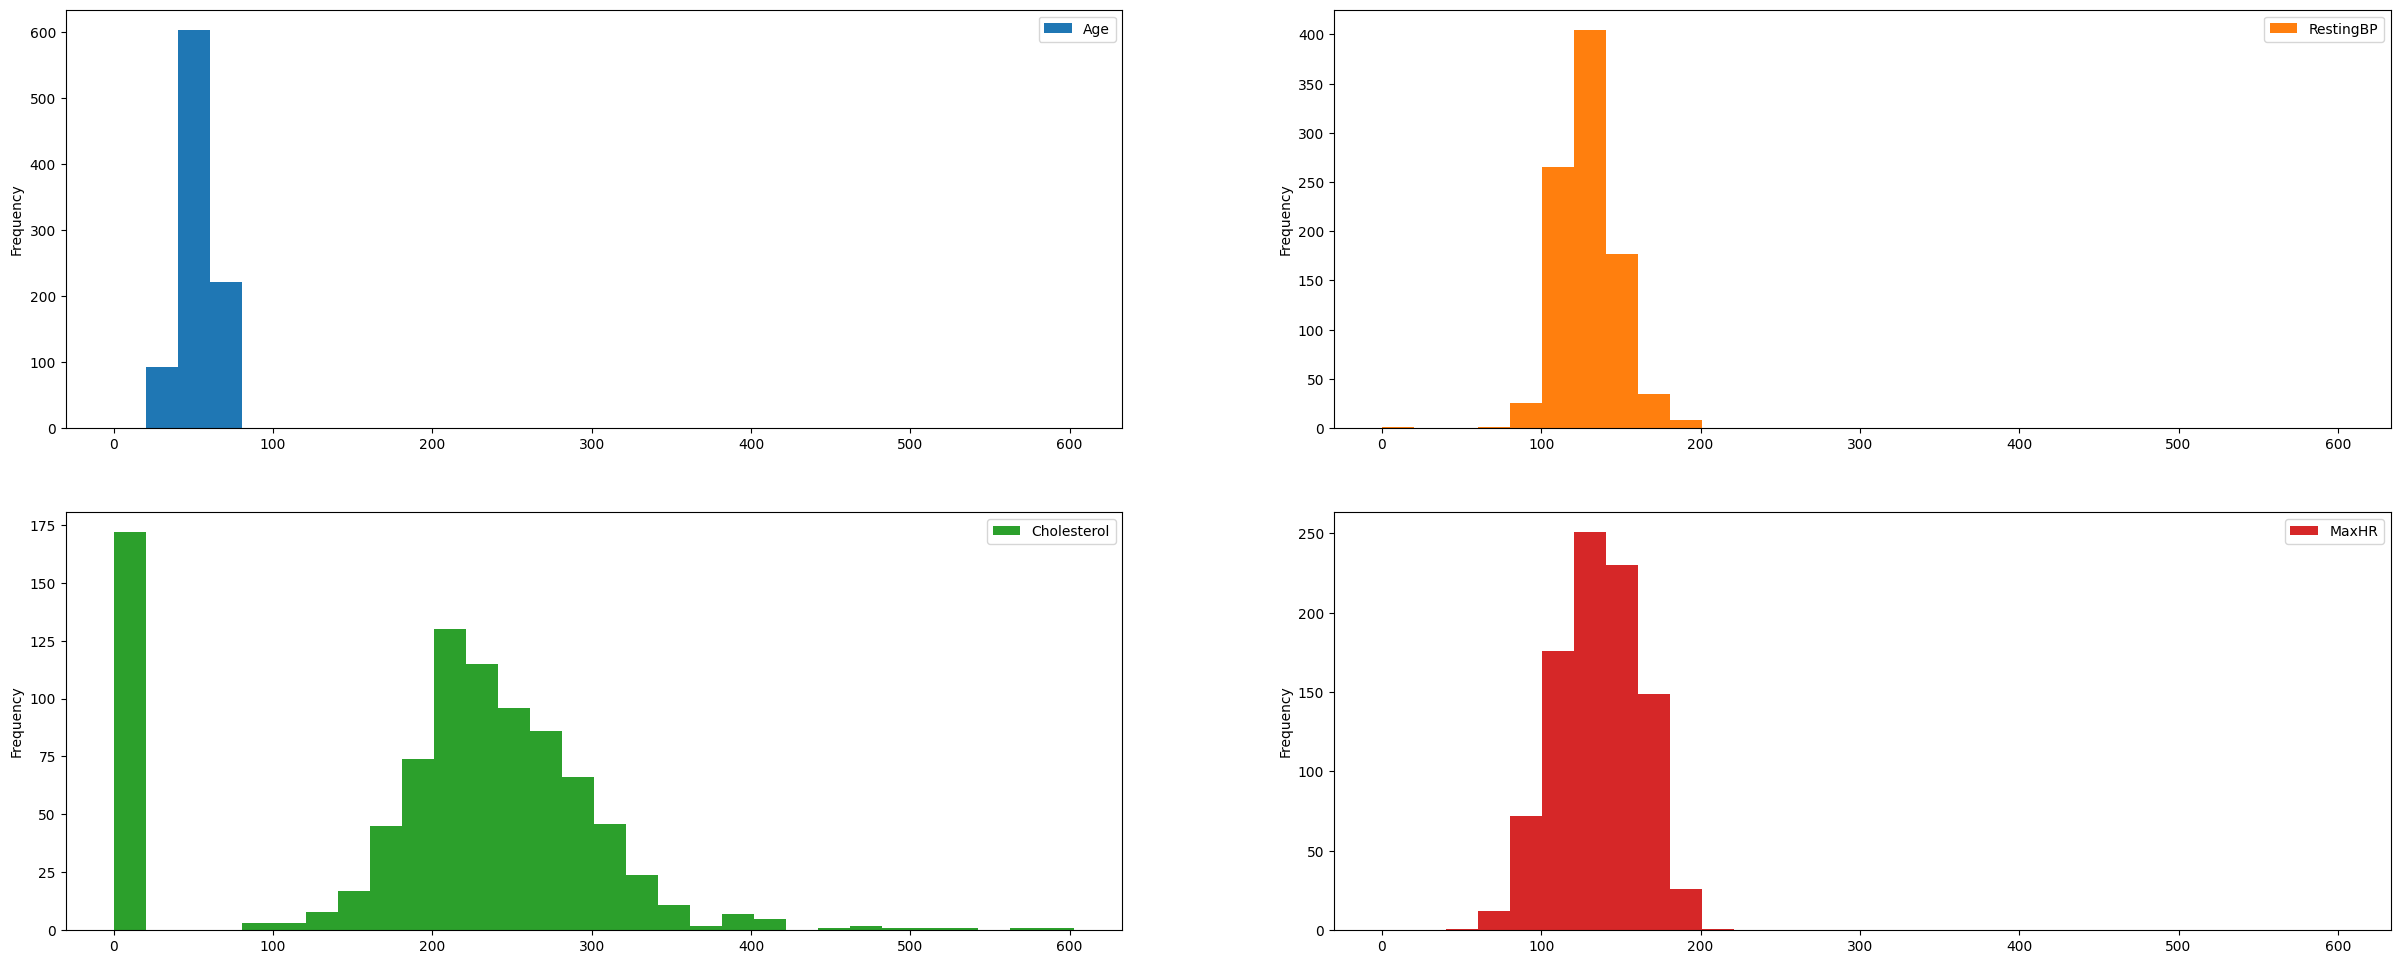

In [12]:
plt.rcParams['figure.figsize']=(30,25)

X_to_show = X.drop(columns=['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'], axis='columns')

X_to_show.plot(kind='hist', bins=30, subplots=True, layout=(4, 2), sharex=False, sharey=False)

plt.show()

In [13]:
correlation = df.corr(numeric_only=True)
correlation

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
Age,1.000000,-0.055750,0.165896,0.254399,-0.095282,0.198039,0.213152,-0.382045,0.215793,0.258612,-0.268264,0.282039
Sex,-0.055750,1.000000,-0.168254,-0.005133,0.200092,-0.120076,0.018343,0.189186,-0.190664,-0.105734,0.150693,-0.305445
ChestPainType,0.165896,-0.168254,1.000000,0.022168,-0.136139,0.116703,0.031383,-0.343654,0.416625,0.245027,-0.317480,0.471354
RestingBP,0.254399,-0.005133,0.022168,1.000000,0.100893,0.070193,0.097661,-0.112135,0.155101,0.164803,-0.075162,0.107589
Cholesterol,-0.095282,0.200092,-0.136139,0.100893,1.000000,-0.260974,0.112095,0.235792,-0.034166,0.050148,0.111471,-0.232741
FastingBS,0.198039,-0.120076,0.116703,0.070193,-0.260974,1.000000,0.050707,-0.131438,0.060451,0.052698,-0.175774,0.267291
RestingECG,0.213152,0.018343,0.031383,0.097661,0.112095,0.050707,1.000000,0.048552,0.036119,0.114428,-0.078807,0.061011
MaxHR,-0.382045,0.189186,-0.343654,-0.112135,0.235792,-0.131438,0.048552,1.000000,-0.370425,-0.160691,0.343419,-0.400421
ExerciseAngina,0.215793,-0.190664,0.416625,0.155101,-0.034166,0.060451,0.036119,-0.370425,1.000000,0.408752,-0.428706,0.494282
Oldpeak,0.258612,-0.105734,0.245027,0.164803,0.050148,0.052698,0.114428,-0.160691,0.408752,1.000000,-0.501921,0.403951


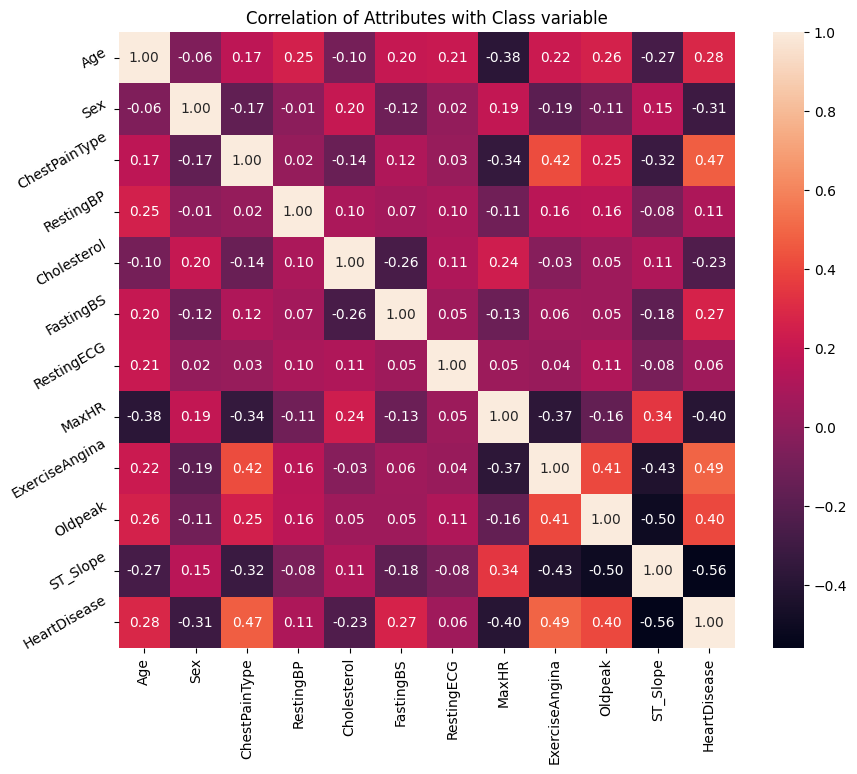

In [14]:
plt.figure(figsize=(10,8))
plt.title('Correlation of Attributes with Class variable')
a = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape

((734, 11), (184, 11))

In [16]:
y_train.shape, y_test.shape

((734,), (184,))

In [17]:
X_train.dtypes

Age                 int64
Sex                 int64
ChestPainType       int64
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG          int64
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
ST_Slope            int64
dtype: object

In [18]:
X_train.isnull().values.any()

False

In [19]:
X_test.isnull().values.any()

False

In [20]:
cols = X_train.columns

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [21]:
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,1.753540,-0.51740,0.817850,0.403985,-1.850065,1.894070,-0.740712,0.793140,1.199391,1.055374,-0.593573
1,-0.817871,-0.51740,0.817850,-0.950506,-1.850065,-0.527964,-0.740712,-0.924506,1.199391,0.577847,-0.593573
2,1.217829,1.93274,-0.254118,1.487578,1.498941,-0.527964,1.770525,0.558916,-0.833757,-0.090691,1.044331
3,1.324972,-0.51740,0.817850,0.403985,-0.556976,-0.527964,-0.740712,-1.666216,1.199391,0.100320,-0.593573
4,0.574977,-0.51740,0.817850,0.403985,-1.850065,-0.527964,0.514906,-0.768356,1.199391,0.100320,-0.593573


In [22]:
X_test.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0.146408,-0.5174,0.817850,-0.950506,-1.850065,1.894070,-0.740712,0.715065,-0.833757,-0.759229,-0.593573
1,1.324972,-0.5174,0.817850,-0.679608,0.959379,-0.527964,1.770525,0.558916,-0.833757,-0.472713,-0.593573
2,-0.282160,-0.5174,0.817850,-1.221404,-1.850065,1.894070,-0.740712,-1.744291,-0.833757,-0.854734,-0.593573
3,0.146408,-0.5174,-0.254118,-0.679608,-1.850065,-0.527964,0.514906,-0.456057,1.199391,1.532901,-0.593573
4,0.896403,-0.5174,-1.326086,0.403985,0.670993,-0.527964,-0.740712,0.597953,-0.833757,0.100320,1.044331


In [23]:
knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [24]:
y_pred = knn.predict(X_test)

In [25]:
y_pred

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1], dtype=int64)

In [26]:
knn.predict_proba(X_test)[:,0]

array([0.        , 0.16666667, 0.        , 0.        , 0.83333333,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.16666667, 0.16666667, 0.        , 1.        ,
       0.        , 0.        , 0.16666667, 0.33333333, 1.        ,
       1.        , 0.        , 0.        , 0.        , 0.33333333,
       0.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 0.        , 1.        , 0.33333333, 1.        ,
       1.        , 0.        , 0.        , 1.        , 0.16666667,
       1.        , 1.        , 0.        , 0.66666667, 1.        ,
       0.16666667, 1.        , 0.83333333, 0.        , 0.        ,
       0.5       , 0.        , 1.        , 0.66666667, 0.5       ,
       0.        , 0.16666667, 0.16666667, 1.        , 0.        ,
       0.33333333, 0.        , 0.66666667, 0.        , 1.        ,
       0.33333333, 0.        , 0.83333333, 0.        , 0.     

In [27]:
knn.predict_proba(X_test)[:,1]

array([1.        , 0.83333333, 1.        , 1.        , 0.16666667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 0.83333333, 0.83333333, 1.        , 0.        ,
       1.        , 1.        , 0.83333333, 0.66666667, 0.        ,
       0.        , 1.        , 1.        , 1.        , 0.66666667,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 0.66666667, 0.        ,
       0.        , 1.        , 1.        , 0.        , 0.83333333,
       0.        , 0.        , 1.        , 0.33333333, 0.        ,
       0.83333333, 0.        , 0.16666667, 1.        , 1.        ,
       0.5       , 1.        , 0.        , 0.33333333, 0.5       ,
       1.        , 0.83333333, 0.83333333, 0.        , 1.        ,
       0.66666667, 1.        , 0.33333333, 1.        , 0.        ,
       0.66666667, 1.        , 0.16666667, 1.        , 1.     

In [28]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.8641


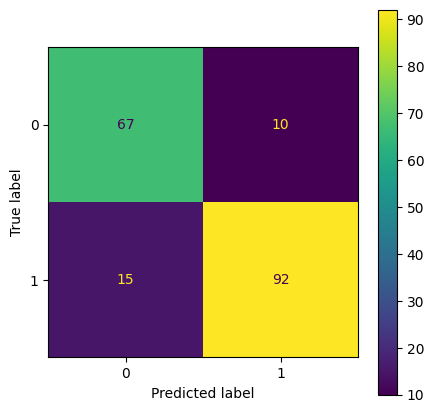

In [29]:
plt.rcParams['figure.figsize']=(5,5)

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=knn.classes_)

display = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=knn.classes_)
display.plot()

# sns.heatmap(conf_mat, annot=True)
plt.show()